In [58]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [3]:
_ = !pip install skforecast

In [59]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [4]:
# Descarga de datos
# ==============================================================================


url = "https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.9/download/indice-precios-al-consumidor-apertura-por-categorias-base-diciembre-2016-mensual.csv"


datos = pd.read_csv(url)
datos.head()

,indice_tiempo,ipc_nivel_general_nacional,ipc_estacionales_nacional,ipc_nucleo_nacional,ipc_regulados_nacional,ipc_nivel_general_gba,ipc_estacionales_gba,ipc_nucleo_gba,ipc_regulados_gba,ipc_nivel_general_pampeana,...,ipc_nucleo_noa,ipc_regulados_noa,ipc_nivel_general_cuyo,ipc_estacionales_cuyo,ipc_nucleo_cuyo,ipc_regulados_cuyo,ipc_nivel_general_patagonia,ipc_estacionales_patagonia,ipc_nucleo_patagonia,ipc_regulados_patagonia
0,2016-12-01,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,...,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
1,2017-01-01,101.5859,101.6969,101.5039,101.8183,101.3130,101.5562,101.3389,101.1274,101.7874,...,101.4339,102.2777,101.7074,100.6608,101.7235,102.2456,102.5593,100.6843,101.8374,106.1556
2,2017-02-01,103.6859,102.3345,103.2105,105.9316,103.8085,102.0783,103.2097,106.3489,103.5312,...,102.9705,106.6823,103.2652,100.3694,103.1488,105.2775,104.2827,101.1740,103.5240,108.7652
3,2017-03-01,106.1476,104.7868,105.2057,110.0057,106.2627,105.8790,105.0891,109.8871,105.8173,...,105.2640,115.9572,105.9238,102.0721,105.2127,110.4082,106.5167,102.5219,105.2611,113.2246
4,2017-04-01,108.9667,108.1867,107.4270,114.4649,109.0613,108.5334,107.4973,113.8991,108.6912,...,107.4536,121.2229,109.4506,106.6856,107.6553,116.8444,108.6517,105.1970,107.0217,116.2906


In [5]:
datos['var_mensual'] = 100 * (datos['ipc_nivel_general_nacional'] - datos['ipc_nivel_general_nacional'].shift(1)) / datos['ipc_nivel_general_nacional'].shift(1)
datos.dropna(inplace=True)
datos.head()

,indice_tiempo,ipc_nivel_general_nacional,ipc_estacionales_nacional,ipc_nucleo_nacional,ipc_regulados_nacional,ipc_nivel_general_gba,ipc_estacionales_gba,ipc_nucleo_gba,ipc_regulados_gba,ipc_nivel_general_pampeana,...,ipc_regulados_noa,ipc_nivel_general_cuyo,ipc_estacionales_cuyo,ipc_nucleo_cuyo,ipc_regulados_cuyo,ipc_nivel_general_patagonia,ipc_estacionales_patagonia,ipc_nucleo_patagonia,ipc_regulados_patagonia,var_mensual
1,2017-01-01,101.5859,101.6969,101.5039,101.8183,101.3130,101.5562,101.3389,101.1274,101.7874,...,102.2777,101.7074,100.6608,101.7235,102.2456,102.5593,100.6843,101.8374,106.1556,1.585900
2,2017-02-01,103.6859,102.3345,103.2105,105.9316,103.8085,102.0783,103.2097,106.3489,103.5312,...,106.6823,103.2652,100.3694,103.1488,105.2775,104.2827,101.1740,103.5240,108.7652,2.067216
3,2017-03-01,106.1476,104.7868,105.2057,110.0057,106.2627,105.8790,105.0891,109.8871,105.8173,...,115.9572,105.9238,102.0721,105.2127,110.4082,106.5167,102.5219,105.2611,113.2246,2.374190
4,2017-04-01,108.9667,108.1867,107.4270,114.4649,109.0613,108.5334,107.4973,113.8991,108.6912,...,121.2229,109.4506,106.6856,107.6553,116.8444,108.6517,105.1970,107.0217,116.2906,2.655830
5,2017-05-01,110.5301,109.0536,109.2069,115.6559,110.4607,108.0039,109.2199,115.2166,110.3005,...,123.2123,111.3091,109.9381,109.5453,117.8142,110.4897,107.3134,109.1808,116.8725,1.434750


In [6]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['indice_tiempo'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'var_mensual': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
print(datos.y.count())
datos.head()

60


,indice_tiempo,ipc_nivel_general_nacional,ipc_estacionales_nacional,ipc_nucleo_nacional,ipc_regulados_nacional,ipc_nivel_general_gba,ipc_estacionales_gba,ipc_nucleo_gba,ipc_regulados_gba,ipc_nivel_general_pampeana,...,ipc_regulados_noa,ipc_nivel_general_cuyo,ipc_estacionales_cuyo,ipc_nucleo_cuyo,ipc_regulados_cuyo,ipc_nivel_general_patagonia,ipc_estacionales_patagonia,ipc_nucleo_patagonia,ipc_regulados_patagonia,y
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,101.5859,101.6969,101.5039,101.8183,101.3130,101.5562,101.3389,101.1274,101.7874,...,102.2777,101.7074,100.6608,101.7235,102.2456,102.5593,100.6843,101.8374,106.1556,1.585900
2017-02-01,2017-02-01,103.6859,102.3345,103.2105,105.9316,103.8085,102.0783,103.2097,106.3489,103.5312,...,106.6823,103.2652,100.3694,103.1488,105.2775,104.2827,101.1740,103.5240,108.7652,2.067216
2017-03-01,2017-03-01,106.1476,104.7868,105.2057,110.0057,106.2627,105.8790,105.0891,109.8871,105.8173,...,115.9572,105.9238,102.0721,105.2127,110.4082,106.5167,102.5219,105.2611,113.2246,2.374190
2017-04-01,2017-04-01,108.9667,108.1867,107.4270,114.4649,109.0613,108.5334,107.4973,113.8991,108.6912,...,121.2229,109.4506,106.6856,107.6553,116.8444,108.6517,105.1970,107.0217,116.2906,2.655830
2017-05-01,2017-05-01,110.5301,109.0536,109.2069,115.6559,110.4607,108.0039,109.2199,115.2166,110.3005,...,123.2123,111.3091,109.9381,109.5453,117.8142,110.4897,107.3134,109.1808,116.8725,1.434750


In [7]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(datos['y'].values.reshape(-1, 1))

datos['y1'] = min_max_scaler.fit_transform(datos['y'].values.reshape(-1, 1))
datos.head()


,indice_tiempo,ipc_nivel_general_nacional,ipc_estacionales_nacional,ipc_nucleo_nacional,ipc_regulados_nacional,ipc_nivel_general_gba,ipc_estacionales_gba,ipc_nucleo_gba,ipc_regulados_gba,ipc_nivel_general_pampeana,...,ipc_nivel_general_cuyo,ipc_estacionales_cuyo,ipc_nucleo_cuyo,ipc_regulados_cuyo,ipc_nivel_general_patagonia,ipc_estacionales_patagonia,ipc_nucleo_patagonia,ipc_regulados_patagonia,y,y1
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,101.5859,101.6969,101.5039,101.8183,101.3130,101.5562,101.3389,101.1274,101.7874,...,101.7074,100.6608,101.7235,102.2456,102.5593,100.6843,101.8374,106.1556,1.585900,0.073720
2017-02-01,2017-02-01,103.6859,102.3345,103.2105,105.9316,103.8085,102.0783,103.2097,106.3489,103.5312,...,103.2652,100.3694,103.1488,105.2775,104.2827,101.1740,103.5240,108.7652,2.067216,0.163816
2017-03-01,2017-03-01,106.1476,104.7868,105.2057,110.0057,106.2627,105.8790,105.0891,109.8871,105.8173,...,105.9238,102.0721,105.2127,110.4082,106.5167,102.5219,105.2611,113.2246,2.374190,0.221278
2017-04-01,2017-04-01,108.9667,108.1867,107.4270,114.4649,109.0613,108.5334,107.4973,113.8991,108.6912,...,109.4506,106.6856,107.6553,116.8444,108.6517,105.1970,107.0217,116.2906,2.655830,0.273998
2017-05-01,2017-05-01,110.5301,109.0536,109.2069,115.6559,110.4607,108.0039,109.2199,115.2166,110.3005,...,111.3091,109.9381,109.5453,117.8142,110.4897,107.3134,109.1808,116.8725,1.434750,0.045426


In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(datos['y'].values.reshape(-1, 1))
datos['y2'] = min_max_scaler.inverse_transform(datos['y1'].values.reshape(-1, 1))
datos.head()

,indice_tiempo,ipc_nivel_general_nacional,ipc_estacionales_nacional,ipc_nucleo_nacional,ipc_regulados_nacional,ipc_nivel_general_gba,ipc_estacionales_gba,ipc_nucleo_gba,ipc_regulados_gba,ipc_nivel_general_pampeana,...,ipc_estacionales_cuyo,ipc_nucleo_cuyo,ipc_regulados_cuyo,ipc_nivel_general_patagonia,ipc_estacionales_patagonia,ipc_nucleo_patagonia,ipc_regulados_patagonia,y,y1,y2
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,101.5859,101.6969,101.5039,101.8183,101.3130,101.5562,101.3389,101.1274,101.7874,...,100.6608,101.7235,102.2456,102.5593,100.6843,101.8374,106.1556,1.585900,0.073720,1.585900
2017-02-01,2017-02-01,103.6859,102.3345,103.2105,105.9316,103.8085,102.0783,103.2097,106.3489,103.5312,...,100.3694,103.1488,105.2775,104.2827,101.1740,103.5240,108.7652,2.067216,0.163816,2.067216
2017-03-01,2017-03-01,106.1476,104.7868,105.2057,110.0057,106.2627,105.8790,105.0891,109.8871,105.8173,...,102.0721,105.2127,110.4082,106.5167,102.5219,105.2611,113.2246,2.374190,0.221278,2.374190
2017-04-01,2017-04-01,108.9667,108.1867,107.4270,114.4649,109.0613,108.5334,107.4973,113.8991,108.6912,...,106.6856,107.6553,116.8444,108.6517,105.1970,107.0217,116.2906,2.655830,0.273998,2.655830
2017-05-01,2017-05-01,110.5301,109.0536,109.2069,115.6559,110.4607,108.0039,109.2199,115.2166,110.3005,...,109.9381,109.5453,117.8142,110.4897,107.3134,109.1808,116.8725,1.434750,0.045426,1.434750


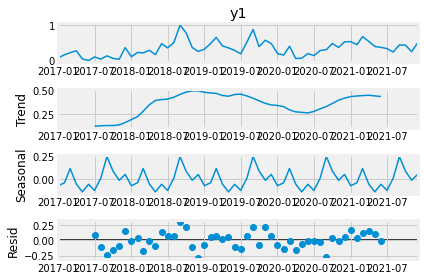

In [11]:
results = seasonal_decompose(datos['y1'])

results.plot()
plt.plot(figsize=(12,4))
plt.show()

<AxesSubplot:xlabel='fecha'>

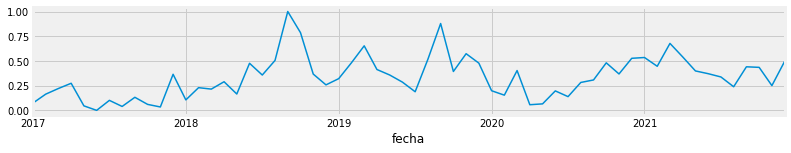

In [12]:
results.observed.plot(figsize=(12,2))

In [14]:
train_len = int(len(datos.y) * 0.8)
print('train len: ', train_len)
test_len = len(datos.y) - train_len
print('test len: ',test_len)

train len:  48
test len:  12


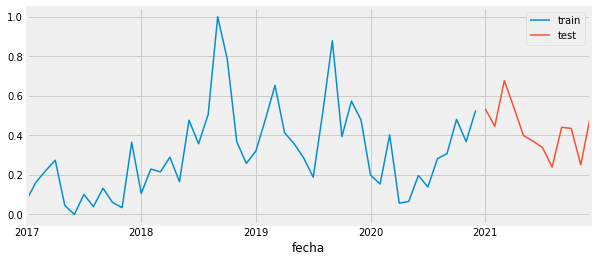

In [15]:
# Separación datos train-test
# ==============================================================================
#steps = 36
steps = test_len
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y1'].plot(ax=ax, label='train')
datos_test['y1'].plot(ax=ax, label='test')
ax.legend();

In [16]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-01-24 15:51:27 
Last fit date: 2022-01-24 15:51:27 
Skforecast version: 0.4.2 

In [17]:
# Predicciones
# ==============================================================================
#steps = 36
steps = test_len
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2021-01-01    0.649079
2021-02-01    0.523007
2021-03-01    0.550413
2021-04-01    0.487397
2021-05-01    0.425371
Freq: MS, Name: pred, dtype: float64

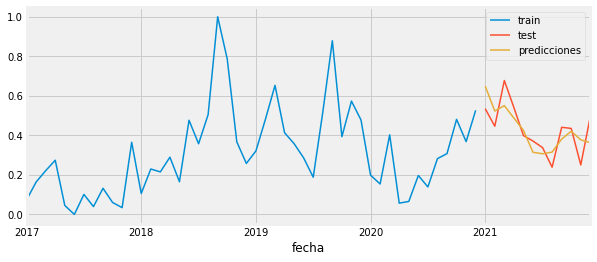

In [18]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y1'].plot(ax=ax, label='train')
datos_test['y1'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [19]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y1'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.007184684435757652


In [20]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid =[i for i in range(1,6)]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.03637825605290035



In [21]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
28,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 100}",0.036378,10,100
10,"[1, 2]","{'max_depth': 10, 'n_estimators': 100}",0.038217,10,100
25,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 500}",0.040778,3,500
8,"[1, 2]","{'max_depth': 5, 'n_estimators': 100}",0.042804,5,100
6,"[1, 2]","{'max_depth': 3, 'n_estimators': 100}",0.043099,3,100
19,"[1, 2, 3, 4]","{'max_depth': 3, 'n_estimators': 500}",0.043493,3,500
11,"[1, 2]","{'max_depth': 10, 'n_estimators': 500}",0.044277,10,500
26,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",0.044555,5,100
9,"[1, 2]","{'max_depth': 5, 'n_estimators': 500}",0.044676,5,500
13,"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 500}",0.045402,3,500


In [43]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 5
             )
forecaster.fit(y=datos_train['y1'])

In [56]:
# Predicciones
# ==============================================================================
#steps = 36
steps = test_len + 1
predicciones = forecaster.predict(steps=steps)

print(predicciones[0])
min_max_scaler.fit(datos['y'].values.reshape(-1, 1))

#use the inverse transform to get the original values
pred = min_max_scaler.inverse_transform(predicciones.values.reshape(-1, 1))
preds = pd.DataFrame(pred, columns=['y'])
preds.index = predicciones.index
print('inflacion mes proximo: ', preds.iloc[-1])


0.7007590746129517
inflacion mes proximo:  y    3.503963
Name: 2022-01-01 00:00:00, dtype: float64


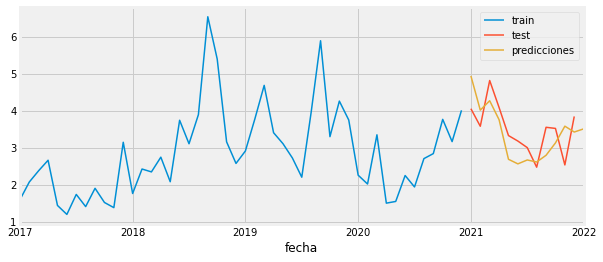

In [57]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
preds['y'].plot(ax=ax, label='predicciones')
ax.legend();